In [114]:
using StatsBase
using Random
using DataStructures
using Parameters
using DataFrames
using Plots


<b>Przyjęte rozkłady czasów obsługi stanowiska dla ludzi i robota

In [115]:
time_robert = [
  10 20;
  20 25;
  30 33;
  40 36;
  50 31;
  60 22      
]

time_alicja = [
  10 25;
  20 40;
  30 33;
  40 28;
  50 22;
  60 18
]

time_szymon = [
  10 20;
  20 28;
  30 35;
  40 23;
  50 20;
  60 15
]

time_lucy = [
  10 60;
  20 70;
  30 25;
  40 12;
  50 8;
  60 40 
]

6×2 Matrix{Int64}:
 10  60
 20  70
 30  25
 40  12
 50   8
 60  40

In [116]:
println("Średni czas Roberta: ",sum(time_robert[:,1] .* time_robert[:,2])/sum(time_robert[:,1]))
println("Średni czas Alicji: ",sum(time_alicja[:,1] .* time_alicja[:,2])/sum(time_alicja[:,1]))
println("Średni czas Szymona: ",sum(time_szymon[:,1] .* time_szymon[:,2])/sum(time_szymon[:,1]))
println("Średni czas Lucy: ",sum(time_lucy[:,1] .* time_lucy[:,2])/sum(time_lucy[:,1]))

Średni czas Roberta: 28.571428571428573
Średni czas Alicji: 25.428571428571427
Średni czas Szymona: 22.047619047619047
Średni czas Lucy: 28.714285714285715


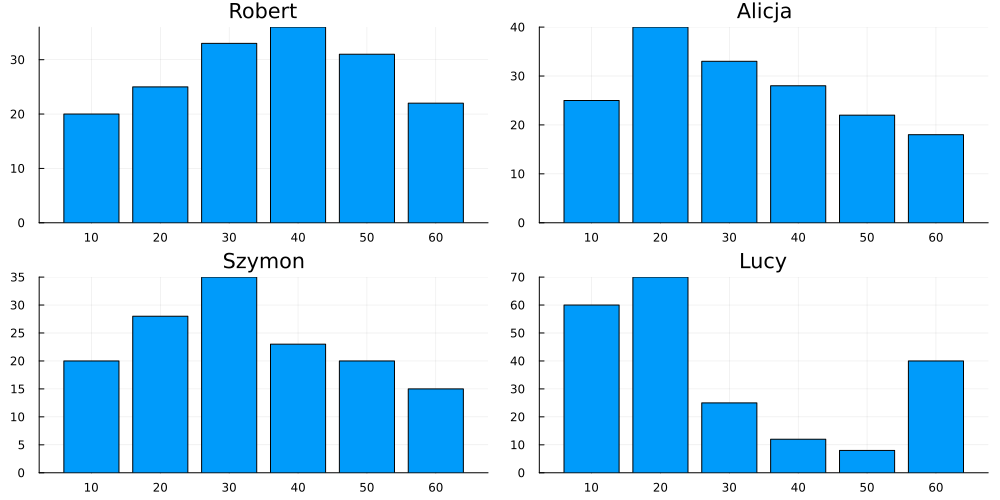

In [167]:
plot(
    bar(time_robert[:,1], time_robert[:,2], title="Robert", legend=false),
    bar(time_alicja[:,1], time_alicja[:,2], title="Alicja", legend=false),
    bar(time_szymon[:,1], time_szymon[:,2], title="Szymon", legend=false),
    bar(time_lucy[:,1], time_lucy[:,2], title="Lucy", legend=false),
    size=(1000, 500),
    layout=(2,2)
)

Przyjęte zmienne

In [118]:
P = 10 #cena
VC_human = 0.015 #koszt za jednostkę czasu produkcji człowieka
VC_machine = 0.010  #koszt za jednostkę czasu produkcji maszyny
error_prob = 0.05 #prawdopodobieństwo błędu maszyny


0.05

Struktura danych pozwalająca modelować linię produkcyjną, elementy struktry posiadają funkcje wskazane przez ich nazwy, doprecyzowując jedynie kilka z nich:
<br>
<br>tick - jeden obrót linii produkcyjnej odznaczający jedno indywidualne zdarzenie
<br>czy_maszyna - wektor wskazujący, które stanowiska zostały obsadzone robotem (true - robot)
<br>error_maszyna - pradopodobieństwo wystąpienia błędu maszyny
<br>log - zapis wszystkich wydarzeń w ramach funkcjonowania linii

In [119]:
@with_kw mutable struct LiniaProdukcyjna
    tick::Int = 0
    stanowisko1_gotowe::Bool = false
    stanowisko2_gotowe::Bool = false
    stanowisko2_zajete::Bool = false
    stanowisko3_zajete::Bool = false
    stanowisko1_rozkladczasu::Matrix{Int}
    stanowisko2_rozkladczasu::Matrix{Int}
    stanowisko3_rozkladczasu::Matrix{Int}
    czy_maszyna::Vector{Bool}
    error_maszyna::Float64 = 0.05
    kolejka::PriorityQueue{Function, Tuple{Int,Int}}=PriorityQueue{Function, Tuple{Int,Int}}()
    ludzie_czas::Int = 0
    maszyny_czas::Int = 0
    stanowisko1_czas::Int = 0
    stanowisko2_czas::Int = 0
    stanowisko3_czas::Int = 0
    skonczone_towary::Int = 0
    log::DataFrame = DataFrame()
end 

LiniaProdukcyjna

Tworzymy listę modeli linii produkcyjnych ze wszystkimi konfiguracjami zastąpienia pracowników przez maszyny

In [134]:
modele = LiniaProdukcyjna[]
konfiguracje = [["Robert", "Alicja", "Szymon"],
                ["Lucy", "Alicja", "Szymon"],
                ["Robert", "Lucy", "Szymon"],
                ["Robert", "Alicja", "Lucy"],
                ["Lucy", "Lucy", "Szymon"],
                ["Robert", "Lucy", "Lucy"],
                ["Lucy", "Alicja", "Lucy"],
                ["Lucy", "Lucy", "Lucy"]]
                
maszyny = [[false, false, false],
           [true, false, false],
           [false, true, false],
           [false, false, true],
           [true, true, false],
           [false, true, true],
           [true, false, true],
           [true, true, true]]

for czy_maszyna in maszyny
    s1 = czy_maszyna[1] ? time_lucy : time_robert
    s2 = czy_maszyna[2] ? time_lucy : time_alicja
    s3 = czy_maszyna[3] ? time_lucy : time_szymon
    push!(modele, LiniaProdukcyjna(stanowisko1_rozkladczasu=s1, 
                                   stanowisko2_rozkladczasu=s2,
                                   stanowisko3_rozkladczasu=s3,
                                   czy_maszyna=czy_maszyna
                                   ))
end

Zadeklarowanie wszystkich funkcji rezprezentujących możliwe zdarzenia w ramach linii produkcyjnej
<br>
* s[]_zaczyna! - osoba lub robot zajmujący stanowisko sprawdza, czy może zacząć obrabiać produkt (stanowisko 1 nie musi tego robić), w przypadku potwierdzenia obrabia produkt w czasie wylosowanym z rozkładu odpowiedniego dla danej osoby lub robota. Roboty niekiedy dokonują pomyłek i nie podają półproduktu dalej
* s[]_done! - osoba lub robot kończą obrabiać produkt i oczekują na podanie go dalej
* krok! - funkcja dokonująca jednego obrotu linii produkcyjne, to znaczy przetwarzająca jedno wydarzenie 

In [121]:
function s1_zaczyna!(linia::LiniaProdukcyjna, czas::Int)
    czas_pracy = sample(linia.stanowisko1_rozkladczasu[:,1], Weights(linia.stanowisko1_rozkladczasu[:,2]))
    linia.stanowisko1_czas += czas_pracy
    if linia.czy_maszyna[1]
        linia.maszyny_czas += czas_pracy
        if rand()<linia.error_maszyna
            enqueue!(linia.kolejka, s1_zaczyna!, (czas+czas_pracy,1))
            return
        end
    else
        linia.ludzie_czas += czas_pracy
    end
    enqueue!(linia.kolejka, s1_done!, (czas+czas_pracy,3))
end
function s1_done!(linia::LiniaProdukcyjna, czas::Int)
    linia.stanowisko1_gotowe = true
    enqueue!(linia.kolejka, s2_zaczyna!, (czas,4))
end
function s2_zaczyna!(linia::LiniaProdukcyjna, czas::Int)
    if linia.stanowisko1_gotowe && !linia.stanowisko2_zajete
        linia.stanowisko1_gotowe = false
        linia.stanowisko2_zajete = true
        czas_pracy = sample(linia.stanowisko2_rozkladczasu[:,1], Weights(linia.stanowisko2_rozkladczasu[:,2]))
        linia.stanowisko2_czas += czas_pracy
        enqueue!(linia.kolejka, s1_zaczyna!, (czas,2))
        if linia.czy_maszyna[2]
            linia.maszyny_czas += czas_pracy
            if rand()<linia.error_maszyna
                linia.stanowisko2_zajete = false
                #enqueue!(linia.kolejka, s2_zaczyna!, (czas+czas_pracy,5))
                return
            end
        else
            linia.ludzie_czas += czas_pracy
        end
        enqueue!(linia.kolejka, s2_done!, (czas+czas_pracy,7))
    end
end
function s2_done!(linia::LiniaProdukcyjna, czas::Int)
    linia.stanowisko2_gotowe = true
    enqueue!(linia.kolejka, s3_zaczyna!, (czas,8))
end
function s3_zaczyna!(linia::LiniaProdukcyjna, czas::Int)
    if linia.stanowisko2_gotowe && !linia.stanowisko3_zajete
        linia.stanowisko2_zajete = false
        linia.stanowisko2_gotowe = false
        linia.stanowisko3_zajete = true
        czas_pracy = sample(linia.stanowisko3_rozkladczasu[:,1], Weights(linia.stanowisko3_rozkladczasu[:,2]))
        linia.stanowisko3_czas += czas_pracy
        enqueue!(linia.kolejka, s2_zaczyna!, (czas,6))
        if linia.czy_maszyna[3]
            linia.maszyny_czas += czas_pracy
            if rand()<linia.error_maszyna
                linia.stanowisko3_zajete = false
                #enqueue!(linia.kolejka, s3_zaczyna!, (czas+czas_pracy,9))
                return
            end
        else
            linia.ludzie_czas += czas_pracy
        end
        enqueue!(linia.kolejka, s3_done!, (czas+czas_pracy,11))
    end
end
function s3_done!(linia::LiniaProdukcyjna, czas::Int)
    linia.stanowisko3_zajete = false
    linia.skonczone_towary += 1
    enqueue!(linia.kolejka, s3_zaczyna!, (czas,10))
end
function krok!(linia::LiniaProdukcyjna, zapisz_log::Bool)
    linia.tick += 1
    zdarzenie, czas_priorytet = dequeue_pair!(linia.kolejka)
    zdarzenie(linia, czas_priorytet[1])
    if zapisz_log
        append!(linia.log, DataFrame(tick=linia.tick, 
                                     czas=czas_priorytet[1], 
                                     zdarzenie=string(zdarzenie), 
                                     skończone_towary=linia.skonczone_towary,
                                     maszyny_czas=linia.maszyny_czas,
                                     ludzie_czas=linia.ludzie_czas,
                                     stanowisko1_czas=linia.stanowisko1_czas,
                                     stanowisko2_czas=linia.stanowisko2_czas,
                                     stanowisko3_czas=linia.stanowisko3_czas))
    end
    return czas_priorytet[1]
end
    

krok! (generic function with 1 method)

In [122]:
#test

s1_zaczyna!(modele[1], 0)
for i in 1:100
    krok!(modele[1],true)
end
modele[1].log

Row,tick,czas,zdarzenie,skończone_towary,maszyny_czas,ludzie_czas,stanowisko1_czas,stanowisko2_czas,stanowisko3_czas
,Int64,Int64,String,Int64,Int64,Int64,Int64,Int64,Int64
1,1,60,s1_done!,0,0,60,60,0,0
2,2,60,s2_zaczyna!,0,0,100,60,40,0
3,3,60,s1_zaczyna!,0,0,140,100,40,0
4,4,100,s1_done!,0,0,140,100,40,0
5,5,100,s2_zaczyna!,0,0,140,100,40,0
6,6,100,s2_done!,0,0,140,100,40,0
7,7,100,s3_zaczyna!,0,0,180,100,40,40
8,8,100,s2_zaczyna!,0,0,220,100,80,40
9,9,100,s1_zaczyna!,0,0,250,130,80,40


Funkcja do przeprowadzenia symulacji działania modelu linii produkcyjnej w czasie 8 godzin

In [123]:
function symulacja!(linia::LiniaProdukcyjna, zapisz_log::Bool)
    linia.tick::Int = 0
    linia.stanowisko1_gotowe = false
    linia.stanowisko2_gotowe = false
    linia.stanowisko2_zajete = false
    linia.stanowisko3_zajete = false
    linia.kolejka=PriorityQueue{Function, Tuple{Int,Int}}()
    linia.ludzie_czas = 0
    linia.maszyny_czas = 0
    linia.stanowisko1_czas = 0
    linia.stanowisko2_czas = 0
    linia.stanowisko3_czas = 0
    linia.skonczone_towary::Int = 0
    linia.log::DataFrame = DataFrame()

    s1_zaczyna!(linia, 0)
    while krok!(linia,zapisz_log) < 3600*8
    end
    return (skończone_towary=linia.skonczone_towary, 
            maszyny_czas=linia.maszyny_czas,
            ludzie_czas=linia.ludzie_czas,
            stanowisko1_czas=linia.stanowisko1_czas,
            stanowisko2_czas=linia.stanowisko2_czas,
            stanowisko3_czas=linia.stanowisko3_czas)
end


symulacja! (generic function with 1 method)

Finalne przeprowadzenie symulacji w liczbie 1000 dla każdej konfiguracji ludzi i robotów. Zapisanie wszystkich wyników do listy ramek danych i zapisanie średnich wartości do ramki danych.

In [130]:
Random.seed!(1)

lista_tabel = DataFrame[]
średnie_wyniki = DataFrame()
for i in 1:8
    df = DataFrame(symulacja!(modele[i],false) for _ in 1:1000)
    lista_tabel = vcat(lista_tabel, df)
    append!(średnie_wyniki, DataFrame(avg_skonczone_towary=mean(df.skończone_towary),
                                      avg_maszyny_czas=mean(df.maszyny_czas),
                                      avg_ludzie_czas=mean(df.ludzie_czas),
                                      avg_stanowisko1_czas=mean(df.stanowisko1_czas),
                                      avg_stanowisko2_czas=mean(df.stanowisko2_czas),
                                      avg_stanowisko3_czas=mean(df.stanowisko3_czas),
                                      koszt=mean(df.maszyny_czas)*VC_machine+mean(df.ludzie_czas)*VC_human,
                                      zysk=round(mean(df.skończone_towary))*P-mean(df.maszyny_czas)*VC_machine-mean(df.ludzie_czas)*VC_human))
end


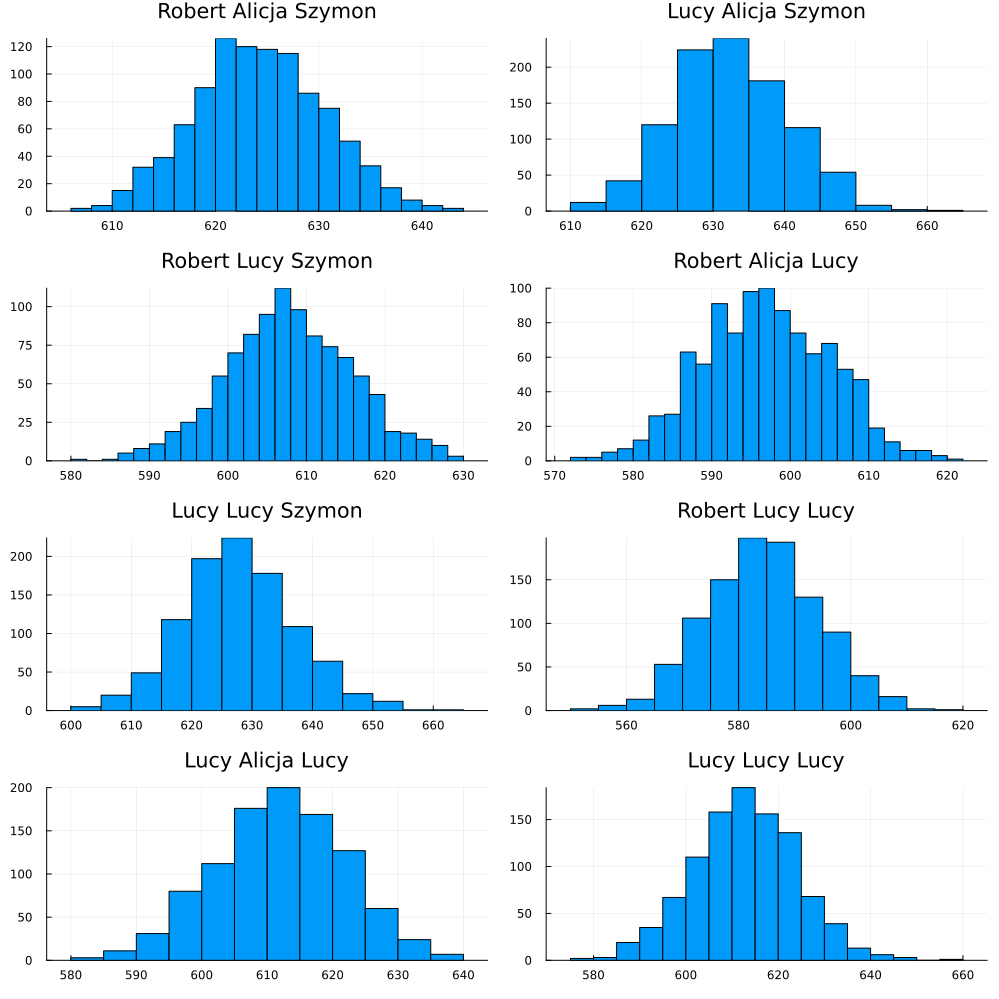

In [162]:
plot(
    histogram(lista_tabel[1].skończone_towary, title=join(konfiguracje[1], " "), legend=false),
    histogram(lista_tabel[2].skończone_towary, title=join(konfiguracje[2], " "), legend=false),
    histogram(lista_tabel[3].skończone_towary, title=join(konfiguracje[3], " "), legend=false),
    histogram(lista_tabel[4].skończone_towary, title=join(konfiguracje[4], " "), legend=false),
    histogram(lista_tabel[5].skończone_towary, title=join(konfiguracje[5], " "), legend=false),
    histogram(lista_tabel[6].skończone_towary, title=join(konfiguracje[6], " "), legend=false),
    histogram(lista_tabel[7].skończone_towary, title=join(konfiguracje[7], " "), legend=false),
    histogram(lista_tabel[8].skończone_towary, title=join(konfiguracje[8], " "), legend=false),
    size=(1000, 1000),
    layout=(4,2)
)

In [131]:
średnie_wyniki

Row,avg_skonczone_towary,avg_maszyny_czas,avg_ludzie_czas,avg_stanowisko1_czas,avg_stanowisko2_czas,avg_stanowisko3_czas,koszt,zysk
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,623.815,0.0,63102.9,22487.4,20114.6,20500.9,946.544,5293.46
2,631.943,18744.8,41118.0,18744.8,20357.3,20760.7,804.219,5515.78
3,607.375,17963.5,43008.9,23048.1,17963.5,19960.9,824.769,5245.23
4,596.428,17633.9,42917.4,22657.2,20260.2,17633.9,820.1,5139.9
5,627.25,38085.6,20583.3,19520.7,18564.9,20583.3,689.606,5580.39
6,583.746,35391.3,23326.8,23326.8,18164.8,17226.5,703.815,5136.19
7,611.485,37159.9,20744.6,19061.4,20744.6,18098.6,682.768,5427.23
8,612.356,57258.5,0.0,20090.6,19079.5,18088.4,572.585,5547.41


Wskazanie konfiguracji z największym zyskiem

In [136]:
najlepsza_konfiguracja = argmax(średnie_wyniki.zysk)
println("Stanowisko 1: ",konfiguracje[najlepsza_konfiguracja][1])
println("Stanowisko 2: ",konfiguracje[najlepsza_konfiguracja][2])
println("Stanowisko 3: ",konfiguracje[najlepsza_konfiguracja][3])

Stanowisko 1: Lucy
Stanowisko 2: Lucy
Stanowisko 3: Szymon
